# Processed Data

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os

Load data.

In [2]:
from splicevo.utils.data_utils import load_processed_data

# Which data to load
subset = "full"

# Load data
data_dir = f"/home/elek/sds/sd17d003/Anamaria/splicevo/data/"

species = "mouse"
data_path = os.path.join(data_dir, f"splits_{subset}", f"{species}", "train") # split for training-test

genome = "human_GRCh37"
data_path = os.path.join(data_dir, f"processed_{subset}", f"{genome}") # or per genome processed data

sequences, labels, alpha, beta, sse, species = load_processed_data(data_path)

# Metadata
meta_fn = os.path.join(data_path, "metadata.json")
with open(meta_fn, "r") as f:
    import json
    meta = json.load(f)

# Test windows metadata
meta_fn = os.path.join(data_path, "metadata.csv")
meta_df = pd.read_csv(meta_fn, dtype={"genome_id": str, "chromosome": str, "window_start": int, "window_end": int, "strand": str})

# Species (if available)
species_name_to_id = meta.get('species_mapping', {})
species_id_to_name = {v: k for k, v in species_name_to_id.items()}

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check the structure of meta_df
print("Test metadata columns:")
print(meta_df.columns.tolist())
print("\nTest metadata shape:", meta_df.shape)
print("\nGenomes: ", meta_df['genome_id'].unique())
for genome in meta_df['genome_id'].unique():
    print("\nChromosomes: ")
    print(" ", genome, ": ", meta_df[meta_df['genome_id'] == genome]['chromosome'].unique())

Test metadata columns:
['genome_id', 'chromosome', 'gene_id', 'strand', 'window_start', 'window_end', 'n_donor_sites', 'n_acceptor_sites']

Test metadata shape: (262386, 8)

Genomes:  ['human_GRCh37']

Chromosomes: 
  human_GRCh37 :  ['11' '1' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22' '3'
 '4' '5' '6' '7' '8' '10' '9' 'X' 'MT' 'Y']


In [4]:
# Check meta structure
print("Metadata keys:", meta.keys())
print("Species mapping:", meta.get('species_mapping', {}))

window = meta['window_size']
context = meta['context_size']

Metadata keys: dict_keys(['genome_id', 'n_sequences', 'n_splice_sites', 'window_size', 'context_size', 'alpha_threshold', 'genome_config', 'created_at', 'sequences_shape', 'labels_shape', 'sequences_dtype', 'labels_dtype', 'usage_conditions', 'usage_condition_mapping', 'files', 'alpha_shape', 'alpha_dtype', 'beta_shape', 'beta_dtype', 'sse_shape', 'sse_dtype'])
Species mapping: {}


## Splice Site Analysis

Extract sequences from genome and examine splice sites.

In [5]:
from splicevo.io.genome import GenomeData
from splicevo.io.gene_annotation import GTFProcessor
from splicevo.utils.sequence_utils import one_hot_encode, one_hot_decode, complement_sequence
import matplotlib.pyplot as plt


# Configuration for genome data
genome_config = {
    "mouse_GRCm38": {
        "genome_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Mus_musculus.fa.gz",
        "gtf_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz"
    },
    "rat_Rnor_5.0": {
        "genome_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Rattus_norvegicus.fa.gz",
        "gtf_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Rattus_norvegicus.gtf.gz"
    },
    "human_GRCh37": {
        "genome_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Homo_sapiens.fa.gz",
        "gtf_path": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz",
    }
}

# Initialize genome loaders
try:
    genome_mouse = GenomeData(
        genome_id="mouse_GRCm38",
        genome_path=genome_config["mouse_GRCm38"]["genome_path"],
        gtf_path=genome_config["mouse_GRCm38"]["gtf_path"]
    ).load_genome()
except Exception as e:
    print(f"Warning: Could not load genome FASTA file: {e}")
    genome_mouse = None
try:
    genome_rat = GenomeData(
        genome_id="rat_Rnor_5.0",
        genome_path=genome_config["rat_Rnor_5.0"]["genome_path"],
        gtf_path=genome_config["rat_Rnor_5.0"]["gtf_path"]
    ).load_genome()
except Exception as e:
    print(f"Warning: Could not load genome FASTA file: {e}")
    genome_rat = None
try:
    genome_human = GenomeData(
        genome_id="human_GRCh37",
        genome_path=genome_config["human_GRCh37"]["genome_path"],
        gtf_path=genome_config["human_GRCh37"]["gtf_path"]
    ).load_genome()
except Exception as e:
    print(f"Warning: Could not load genome FASTA file: {e}")
    genome_human = None

# Extract usage conditions from metadata
usage_conditions = meta.get('usage_conditions', [])

Analyze splice sites in selected windows - either by window indices or by genomic coordinates.

In [6]:
from splicevo.utils.analysis_utils import analyze_splice_sites

# Analyze several random sequences
human_indices = np.array([0, 5, 10])
analyze_splice_sites(
    test_seq=sequences,
    test_labels=labels,
    test_meta_df=meta_df,
    test_sse=sse,
    test_alpha=alpha,
    test_beta=beta,
    genome=genome_human,
    window_indices=human_indices,
    usage_conditions=usage_conditions,
    context_size=context
)

SPLICE SITE ANALYSIS


Window 1 (index 0): hum.10006 on chromosome 11 (- strand)
Genomic location: 11:18134190-18135190
Donor sites: 0, Acceptor sites: 1

Sequence from FASTA (length=1900):
AAATCCGAAGTAATGACTTCAACAAGTATCCTAATAGAATAATAGAAAAGATAAAATACTTGGTATATTAATATCCGAATATCAACCAGGTATAATACCA...

Sequence from processed data (length=1900):
AAATCCGAAGTAATGACTTCAACAAGTATCCTAATAGAATAATAGAAAAGATAAAATACTTGGTATATTAATATCCGAATATCAACCAGGTATAATACCA...

Donor site positions in sequence: []

Acceptor site positions in sequence: [0]
Sequences around acceptor sites (±5bp):
  AAATCCG
  ^^

  Usage patterns at splice sites:
    Acceptor sites:
      Position 0:
        Liver_12: SSE=0.0000

Window 2 (index 5): hum.10006 on chromosome 11 (- strand)
Genomic location: 11:18266190-18267190
Donor sites: 1, Acceptor sites: 3

Sequence from FASTA (length=1900):
TGTCGGTACGACACTCAACCCCAAAGTTGTATATGTAAAACCGTTCTATGTCAAGTGAGGTCTCGTGACGGTGAAGGTGTCGACCGAAGGGTCCCCAAAA...

Sequence from processed data (length=1900):
TGT

In [7]:
from splicevo.utils.analysis_utils import analyze_splice_sites

# Inspect specific human genomic coordinates and extract data for plotting
genomic_targets = [
    ('21', 27369675, 27369731, '-'),
    ('1', 110167925, 110168055, '+')
]
analysis_data = analyze_splice_sites(
    test_seq=sequences,
    test_labels=labels,
    test_meta_df=meta_df,
    test_sse=sse,
    test_alpha=alpha,
    test_beta=beta,
    genome=genome_human,
    usage_conditions=usage_conditions,
    genomic_coords=genomic_targets,
    context_size=context,
    return_data=True,
    verbose = True
)

Found 2 windows overlapping specified coordinates:
  Window 88002: 1:110167901-110168901 (+)
  Window 131664: 21:27369083-27370083 (-)

SPLICE SITE ANALYSIS


Window 1 (index 88002): hum.3042 on chromosome 1 (+ strand)
Genomic location: 1:110167901-110168901
Donor sites: 181, Acceptor sites: 178

Sequence from FASTA (length=1900):
GGTCTGATCCTGGGTTGCCTGCCCTGGGAGCTGCAGGCTGGGGGTCCCTGGTGTGGCCGCCTGGTCCTTACCAAGCACCTGGTGTGTGTCTCTGAGGGTG...

Sequence from processed data (length=1900):
GGTCTGATCCTGGGTTGCCTGCCCTGGGAGCTGCAGGCTGGGGGTCCCTGGTGTGGCCGCCTGGTCCTTACCAAGCACCTGGTGTGTGTCTCTGAGGGTG...

Donor site positions in sequence: [155]
Sequences around donor sites (±5bp):
  TCTGGGAGGTAG
       ^^

Acceptor site positions in sequence: [23]
Sequences around acceptor sites (±5bp):
  CTGCCCTGGGAG
       ^^

  Usage patterns at splice sites:
    Donor sites:
      Position 155:
        Brain_1: SSE=0.7890
        Brain_4: SSE=0.5710
        Brain_5: SSE=0.6110
        Brain_7: SSE=0.4000
        Brain_9: SS

## Splice Site Usage Plots

Visualize SSE (Splice Site Efficiency) usage patterns across tissues and timepoints.

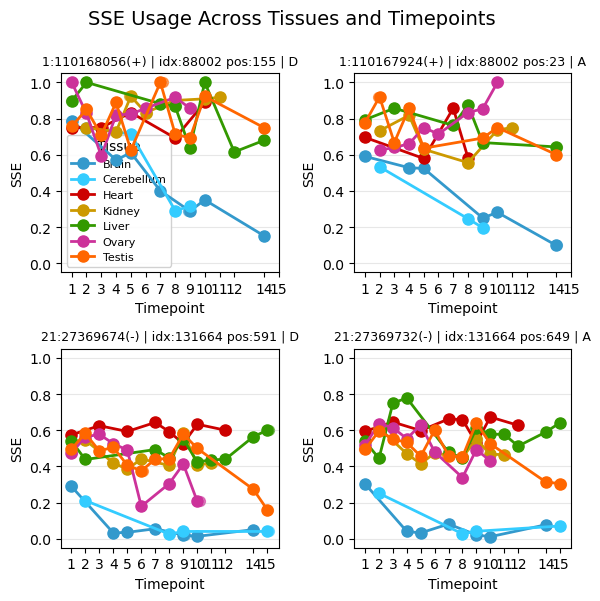

In [10]:
from splicevo.utils.plotting_utils import plot_splice_site_usage

# Colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

# Plot SSE usage across tissues (lines) and timepoints (x-axis) for all splice sites
if analysis_data:
    fig, df = plot_splice_site_usage(
        analysis_data, 
        tissue_colors=tissue_colors,
        figsize = (6, 6),
        grid_cols = 2)
    if fig:
        plt.show()